In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_log_error, r2_score, make_scorer
from sklearn.model_selection import learning_curve

In [2]:
train = pd.read_csv('training.csv', parse_dates=['transaction_date'])
card_group = pd.read_csv('mcc_group_definition.csv')
transaction = pd.read_csv('transaction_types.csv')


In [3]:
train2 = train.merge(card_group, on='mcc_group', how='left').drop('mcc_group', axis=1)
# dropping the unnecessary columns
train2 = train2.drop(['dataset_transaction','dataset_user'], axis=1)
# performing left join (just like sql) and then dropping mcc group. 
# well you can really drop all the unncecessarry groups even at the end
# Do this as an insight at the end. When we see no links in the plots created!

In [4]:
# no trend can be observed
#plt.plot(train2['transaction_date'],train2['amount_n26_currency'])

In [5]:
train2 = (train2.merge(transaction, left_on='transaction_type', right_on='type', suffixes=('_card', '_transaction'))
           .drop(['type','transaction_type'], axis=1))
# merging the transaction type with respect to the type from the train dataframe. That is why we do not have NAN. Since we only merged MCC group we have NAN 
# a string indicating the suffix to add to overlapping column names in left and right respectively.In this case explanation. Since we do want 
# train2 and transaction does not have any common columns so we are selectively applying and testing columns
# change the name od _card suffix to _train to better understand what is exactly referred to.

In [9]:
train2

,user_id,transaction_date,amount_n26_currency,explanation_card,explanation_transaction,direction,agent
0,a78884f5e76951188c1e719d4956773a,2016-02-01,350,NaN,Debit Transfer,Out,Bank Account
1,b0333294fef6ff1299102a70ad46b126,2016-02-01,202,NaN,Debit Transfer,Out,Bank Account
2,7b8d2a2780adae0cd0c248e92c1b28dc,2016-02-01,291,NaN,Debit Transfer,Out,Bank Account
3,cc4abaa500f7db4390ae3f02bd36d805,2016-02-01,214,NaN,Debit Transfer,Out,Bank Account
4,49b99d1d5ba028566639e8b3eb7c055b,2016-02-01,272,NaN,Debit Transfer,Out,Bank Account
...,...,...,...,...,...,...,...
408541,67b86e1168dfe526708ea275ac0a71a8,2016-07-29,11,NaN,Transferwise Transaction,Out,Partner
408542,fff08c7a5cfb93b873149159be9f7976,2016-07-29,40,NaN,Transferwise Transaction,Out,Partner
408543,2018aea439dab366b6ddf6f4df704342,2016-07-29,185,NaN,Transferwise Transaction,Out,Partner
408544,406b16e6a28b54c935763b6598bfa272,2016-07-30,71,NaN,Transferwise Transaction,Out,Partner


In [55]:
f = train2.groupby(['explanation_transaction',pd.Grouper(key='transaction_date',freq='W')]).size()

<AxesSubplot:xlabel='explanation_transaction,transaction_date'>

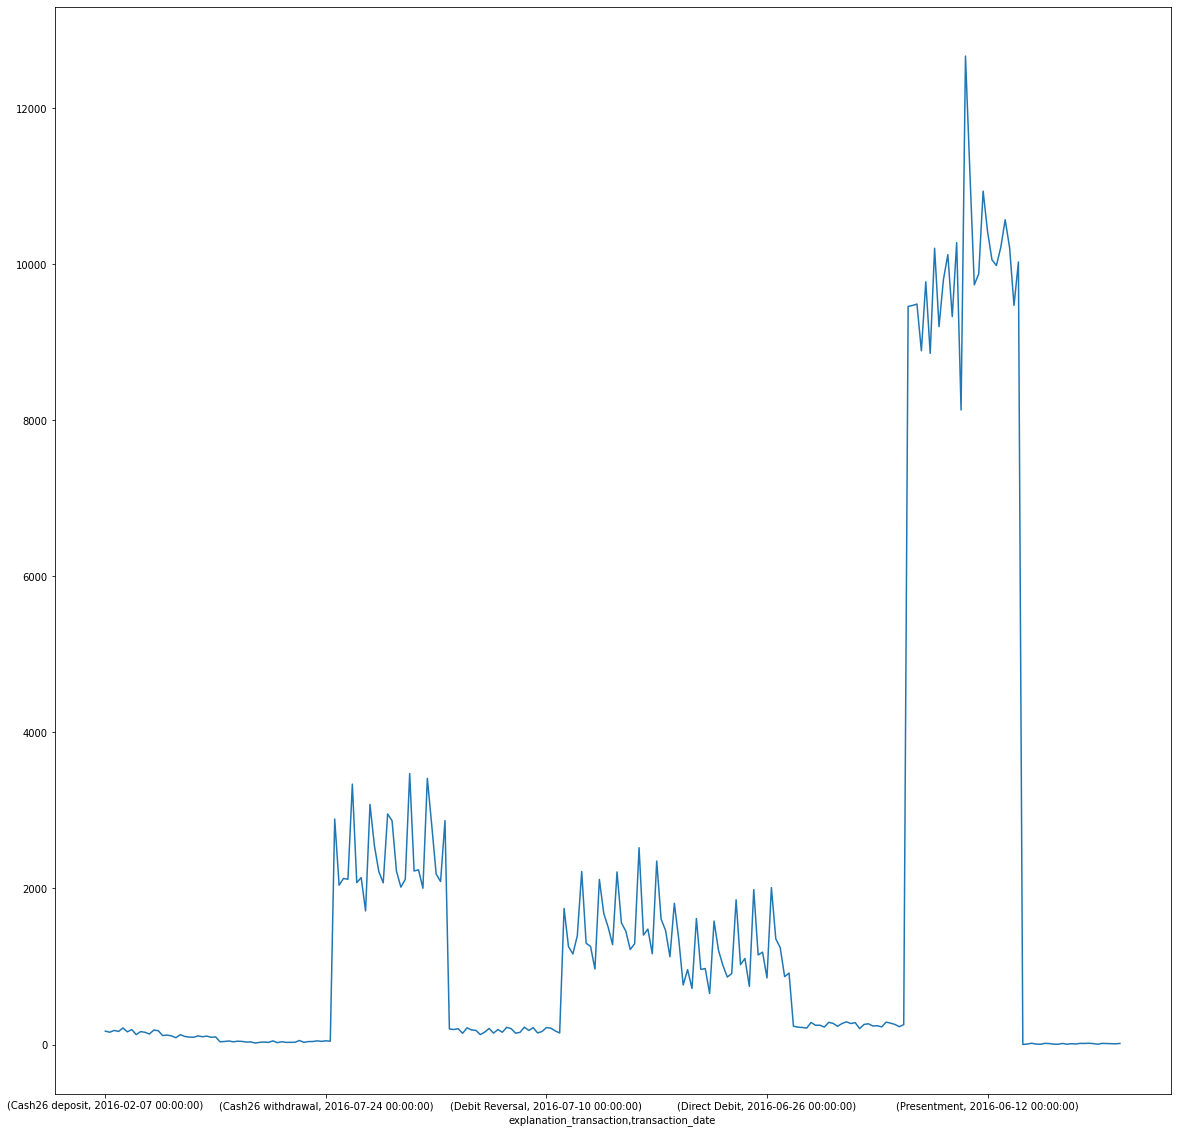

In [56]:
plt.figure(figsize=(20, 20))
f.plot()

In [27]:
f = f.set_index('transaction_date')

AttributeError: 'DataFrameGroupBy' object has no attribute 'set_index'

In [13]:
def plot_bar(feature):
    #plt.plot(feature.to_numpy(), train2[feature].value_counts().index)
    g = sns.catplot(x=feature, 
                    data=train2,
                    order = train2[feature].value_counts().index,
                    kind='count')
    g.set_xticklabels(rotation=90)


In [24]:
def weekly_popularity_trend(feature):
    """
    Feature popularity on weekly basis
    """
    f = train2.groupby([feature, pd.Grouper(key='transaction_date',freq='W')]).size().reset_index()
    print(f)
    f['transaction_date'] = f['transaction_date'].dt.date

    # what does size.reset index do!
    f.columns = [feature,'transaction_date','count']
    #f["transaction_date"] = pd.to_datetime(f["transaction_date"])
    sns.catplot(x="transaction_date", 
            y = 'count',
            hue = feature, 
            data=f, 
            kind='point', 
            height=7, 
            aspect= 2,
            palette='Paired')
    _ = plt.xticks(rotation=90)
    
    

      explanation_transaction transaction_date    0
0              Cash26 deposit       2016-02-07  172
1              Cash26 deposit       2016-02-14  158
2              Cash26 deposit       2016-02-21  181
3              Cash26 deposit       2016-02-28  168
4              Cash26 deposit       2016-03-06  213
..                        ...              ...  ...
226  Transferwise Transaction       2016-07-03   15
227  Transferwise Transaction       2016-07-10   13
228  Transferwise Transaction       2016-07-17   10
229  Transferwise Transaction       2016-07-24    9
230  Transferwise Transaction       2016-07-31   14

[231 rows x 3 columns]


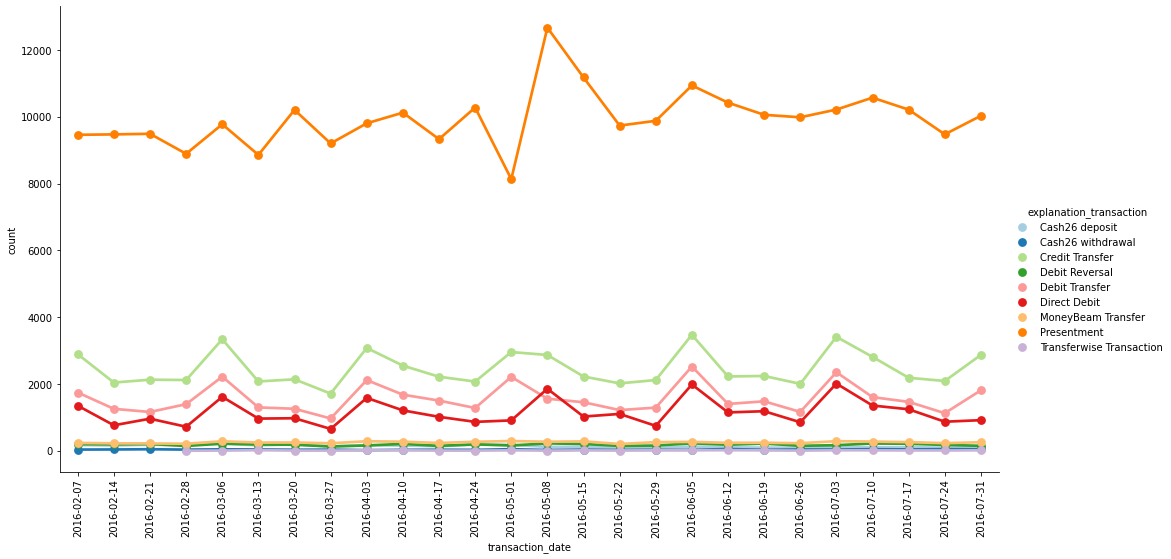

In [25]:
weekly_popularity_trend('explanation_transaction')
# assign colours as the atm has the same coloir

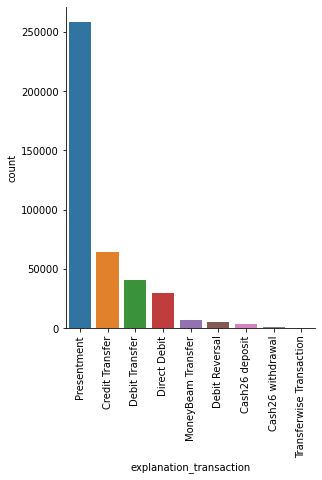

In [10]:
plot_bar('explanation_transaction')
# a bar plot way of explaining that ATM is the most popular way of taking out money aka expenses

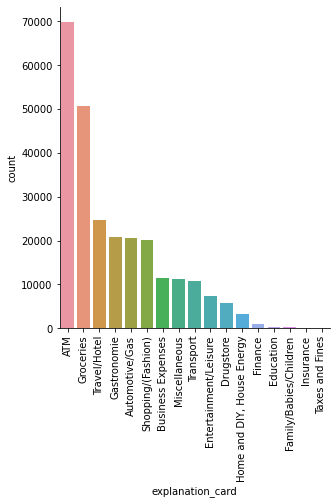

In [11]:
plot_bar('explanation_card')


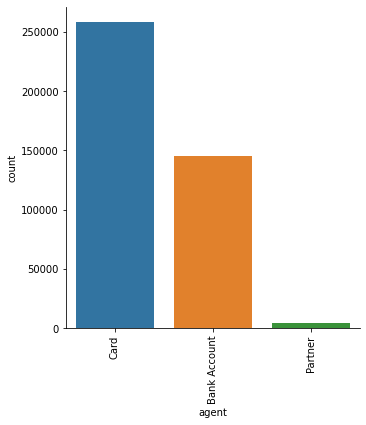

In [12]:
plot_bar('agent')
# write the insights received from this dataset

In [13]:
train2['agent'].unique()

array(['Bank Account', 'Card', 'Partner'], dtype=object)

ValueError: x must be a label or position

In [ ]:
# giving insighst about the fact that there are a lot of debit transactions than credit 

In [ ]:
# Segregating the data as per the direction 
in_data = train2.query("direction == 'In'").drop(['direction','explanation_card','explanation_transaction','agent'], axis=1)
out_data = train2.query("direction == 'Out'").drop(['direction','explanation_card','explanation_transaction','agent'], axis=1)

In [ ]:

class DateEncoder(TransformerMixin, BaseEstimator):
    
    """
    Create date features in the pipeline.
    """
    
    def fit(self, X, y=None):
        return self
    

    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            
            col = 'transaction_date'
            # day of the week so 0 - 6
            X[f"{col}_weekday"] = X[col].dt.dayofweek
            # weeks so 0 to last week of the year
            X[f"{col}_week"] = X[col].dt.week
            # 0 to 30th day of the week
            X[f"{col}_day_week"] = X[col].dt.day
            
            self.names = X[[x for x in X.columns if '_week' in x]].columns.tolist()
            return X[[x for x in X.columns if '_week' in x]].values
        else:
            raise Exception("Only supported for pd.DataFrame")
    
    def get_feature_names(self):
        return self.names
    
    
class MakeTSFeatures(TransformerMixin, BaseEstimator):
    
    """
    Created aggregate lag features in the pipeline. 
    """
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            
            lags = [1,2,7]
            for lag in lags:
                # lag feature
                # this previous lag mean is ok if removed. At most it only tells about how much previous lag is present
                X[f'prev_lag_mean_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).fillna(0)
                # rolling average
                X[f'prev_lag_rolling_mean_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).rolling(2).mean().fillna(0)
                X[f'prev_lag_rolling_std_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).rolling(2).std().fillna(0)
                # cumulative average
                X[f'prev_lag_expand_mean_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).expanding().mean().fillna(0)
                X[f'prev_lag_expand_std_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).expanding().std().fillna(0)

                # exponential moving average
                X[f'prev_lag_ewm_mean_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).ewm(0.1).mean().fillna(0)
                X[f'prev_lag_ewm_std_{lag}'] = X.groupby(['user_id'])['amount_n26_currency'].shift(lag).ewm(0.1).std().fillna(0)
                # calculating the std of each
                
            self.names = X[[x for x in X.columns if 'prev_' in x]].columns.tolist()
            return X[[x for x in X.columns if 'prev_' in x]].values
        else:
            raise Exception("Only supported for pd.DataFrame")
    
    def get_feature_names(self):
        return self.names

In [ ]:
def generate_pipeline(**kwargs):
    
    features = ColumnTransformer(
        [('date_features',DateEncoder(), ['transaction_date']),
         ('time_series_features', MakeTSFeatures(), ['user_id','amount_n26_currency'])        
        ]
    )
    print(features)
    
    clf = XGBRegressor(n_estimators=100, random_state=42, booster='gbtree')
        
    model = Pipeline([
    ('features', features),
    # ('clf', clf)
]) 
    return model

params_xgb = {

     'clf__max_depth': (3,5,10,20),
     'clf__learning_rate': (0.1,0.01,0.05, 0.2),
     'clf__subsample': (.5,.7,.8,.9), 
     'clf__colsample_bytree': (.5,.7,.8,.9),

}

In [ ]:
 model = generate_pipeline()


In [ ]:
#ahh so the user ids are repeated as they make more and more transactions

In [ ]:
# split data set 
train = in_data[in_data['transaction_date'].dt.month < 7].reset_index(drop=True) # from feb to june
test = in_data[in_data['transaction_date'].dt.month == 7].reset_index(drop=True) # test july

y_train = np.log1p(train['amount_n26_currency'])

In [ ]:
# # 

# def test_stationarity(timeseries, title):
    
#     #Determing rolling statistics

#     rolmean = timeseries.groupby(['user_id'])['amount_n26_currency'].rolling(window=12).mean().fillna(0)
#     rolstd = timeseries.groupby(['user_id'])['amount_n26_currency'].rolling(window=12).std().fillna(0)
#     fig, ax = plt.subplots(figsize=(16, 4))
#     ax.plot(range(len(timeseries['amount_n26_currency'])), timeseries['amount_n26_currency'], label= title)
#     ax.scatter(range(len(rolmean)),rolmean.to_numpy(), label='rolling mean',color='yellow');
#     ax.plot(rolstd.to_numpy(), label='rolling std (x10)');
#     ax.legend()

In [ ]:
#  test_stationarity(train,'raw data')

In [ ]:
# fit the pipeline
model.fit(train)

# initialise the model and fit
xgb = XGBRegressor(booster='gbtree', random_state=42)
xgb.fit(model.transform(train), y_train)

In [ ]:
plt.bar(train['transaction_date'],train['amount_n26_currency'])

In [ ]:
y_pred = xgb.predict(model.transform(test))


In [ ]:
baseline_model_predictions = [test['amount_n26_currency'].mean()]* test.shape[0]


In [ ]:
rmsle = np.sqrt(mean_squared_log_error(test['amount_n26_currency'], baseline_model_predictions))


In [ ]:
print(rmsle)


In [ ]:
rmsle_score = np.sqrt(mean_squared_log_error(test['amount_n26_currency'], np.exp(y_pred)))


In [ ]:
print(f"rmsle score: {rmsle_score}")
# lower rmsle score is equal to better performance

In [ ]:
predictions = pd.DataFrame({'y_true': test['amount_n26_currency'], 'y_pred': np.exp(y_pred)})

plt.figure(figsize=(16,6))
# sns.stripplot(predictions['y_pred'],data=predictions,label='pred',color='yellow')
# sns.stripplot(predictions['y_true'],data=predictions,label='true',color='green')

plt.scatter(range(predictions.shape[0]), predictions['y_pred'], label='pred', linestyle='dashed',)
plt.scatter(range(predictions.shape[0]), predictions['y_true'], label='true', linestyle='dashed',alpha=0.4)
plt.ylabel('amount n26 currency')
plt.legend();

In [ ]:
# plot feature importance
# search.best_estimator_.named_steps
feature_names = (model.named_steps['features'].named_transformers_['date_features'].get_feature_names() + 
                model.named_steps['features'].named_transformers_['time_series_features'].get_feature_names())

feature_imp = pd.DataFrame(sorted(zip(xgb.feature_importances_ ,feature_names)), columns=['Value','Feature'])

plt.figure(figsize=(20, 30))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.scatter(feature_imp['Value'].sort_values(ascending=False),feature_imp['Feature'])


#plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

# plt.title('XGB Features')
# plt.show()